In [1]:
from pprint import pprint
import functools

import pandas as pd
import torch
from torch.utils.data import DataLoader
from datasets import Dataset
import torch.nn.functional as F
import pytorch_lightning as pl
from transformers import AutoModelForSequenceClassification, CamembertForMaskedLM, AutoTokenizer, AutoConfig
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, f1_score

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
camembert = CamembertForMaskedLM.from_pretrained('camembert-base')
camembert.roberta.embeddings

CamembertEmbeddings(
  (word_embeddings): Embedding(32005, 768, padding_idx=1)
  (position_embeddings): Embedding(514, 768, padding_idx=1)
  (token_type_embeddings): Embedding(1, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

## data processing

In [3]:
df = pd.read_csv('../data/esg_fr_classification.csv', encoding='utf-8', sep=',')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# rename text_fr column to text and esg_category to label
df = df.rename(columns={'text_fr': 'text'})
print(df.head())

# add label column that ids the esg_category
df['label'] = df['esg_category'].factorize()[0] 

df['esg_category'].value_counts()

df.head()

                                                text     esg_category
0  Le président iranien utilise le discours de l'...          non-esg
1  Le changement climatique menace une orchidée b...  environnemental
2  Le Premier ministre néo-zélandais @jacindaarde...  environnemental
3  La France veut interdire la discrimination con...           social
4  Labor pour rejoindre les Verts pour s'opposer ...  environnemental


,text,esg_category,label
0,Le président iranien utilise le discours de l'...,non-esg,0
1,Le changement climatique menace une orchidée b...,environnemental,1
2,Le Premier ministre néo-zélandais @jacindaarde...,environnemental,1
3,La France veut interdire la discrimination con...,social,2
4,Labor pour rejoindre les Verts pour s'opposer ...,environnemental,1


In [4]:
from sklearn.model_selection import train_test_split

train_size = 0.02
test_size = 0.01
validation_size = 0.01

# train, test and validation split
df_train, df_temp = train_test_split(df, train_size=train_size, stratify=df.label, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp.label, random_state=42)

print(f"train size: {df_train.shape} \t test size: {df_test.shape} \t validation size: {df_val.shape}")

train size: (339, 3) 	 test size: (8324, 3) 	 validation size: (8323, 3)


C:\Users\azeem\AppData\Local\Temp\ipykernel_22652\2982791418.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


count    339.000000
mean     147.430678
std       27.589399
min       25.000000
25%      128.500000
50%      148.000000
75%      166.500000
max      276.000000
Name: len, dtype: float64

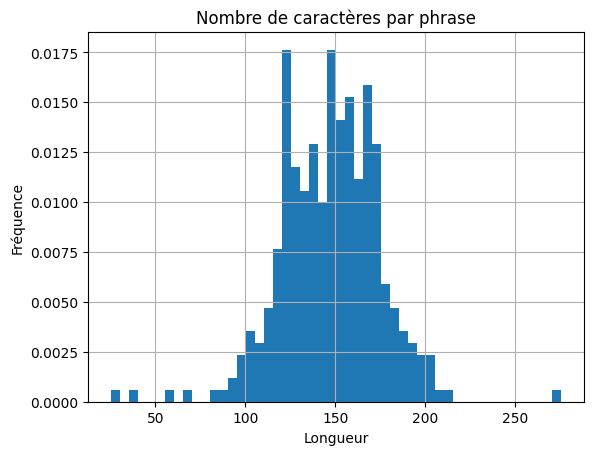

In [5]:
df_train["len"] = df_train["text"].apply(lambda x: len(x.split()))
ax = df_train["len"].hist(density=True, bins=50)
ax.set_xlabel("Longueur")
ax.set_ylabel("Fréquence")
ax.set_title("Nombre de caractères par phrase")
ax.figure.show()

df_train["len"].describe()

### tokenization

In [6]:
def tokenize_batch(samples, tokenizer):
    text = [sample["text"] for sample in samples]
    labels = torch.tensor([sample["label"] for sample in samples])
    str_labels = [sample["esg_category"] for sample in samples]
    # The tokenizer handles
    # - Tokenization (amazing right?)
    # - Padding (adding empty tokens so that each example has the same length)
    # - Truncation (cutting samples that are too long)
    # - Special tokens (in CamemBERT, each sentence ends with a special token </s>)
    # - Attention mask (a binary vector which tells the model which tokens to look at. For instance it will not compute anything if the token is a padding token)
    tokens = tokenizer(text, padding="longest", return_tensors="pt", truncation=True)

    return {"input_ids": tokens.input_ids, "attention_mask": tokens.attention_mask, "labels": labels, "str_labels": str_labels, "sentences": text}

In [7]:
tokenizer = AutoTokenizer.from_pretrained('camembert-base')

C:\Users\azeem\AppData\Local\Temp\ipykernel_22652\2238216375.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


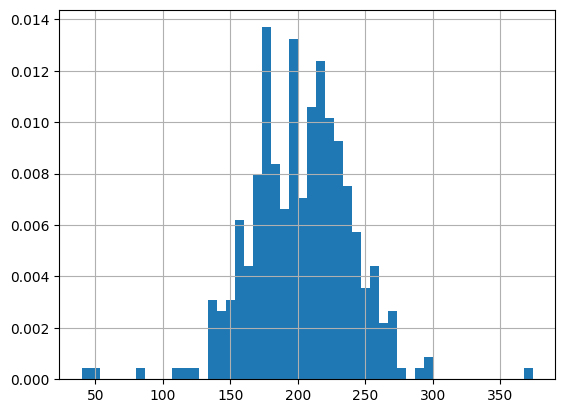

In [22]:
# take the top 3 longest sentences in terms of charcters from the training set take their text from text column and tokenize them
# batch_sentences = df_train.sort_values(by="len", ascending=False).head(3)["text"].tolist()
# tokenizer_output = tokenizer(batch_sentences, padding="longest", return_tensors="pt",)
# tokenizer_output

def check_tokenized_lengths(sentences,tokenizer, model_name='camembert-base'):
    """
    Function to check the lengths of sentences after tokenization.

    Parameters:
    sentences (list of str): A list of sentences to be tokenized.
    model_name (str): The model name to load the appropriate tokenizer.

    Returns:
    dict: A dictionary with original sentences as keys and their tokenized lengths as values.
    """
    lengths = {}

    for sentence in sentences:
        tokens = tokenizer.encode(sentence, add_special_tokens=True,truncation=True, return_tensors="pt")
        lengths[sentence] = len(tokens)

    return lengths

df_train["len_tokens"] = df_train["text"].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))
ax = df_train["len_tokens"].hist(density=True, bins=50)
ax.figure.show()

In [8]:
# Convert df to Hugging Face Datasets
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)
val_dataset = Dataset.from_pandas(df_val)

val_dataloader = DataLoader(val_dataset, collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer), batch_size=16)
print(next(iter(val_dataloader))['input_ids'])
print(next(iter(val_dataloader))['attention_mask'])
print(next(iter(val_dataloader))['labels'])


tensor([[    5, 26772,    25,  ...,     1,     1,     1],
        [    5, 25498,    21,  ...,     1,     1,     1],
        [    5,  9529,   793,  ...,     1,     1,     1],
        ...,
        [    5,   188,   452,  ...,     1,     1,     1],
        [    5,  9290, 28650,  ...,     1,     1,     1],
        [    5,    71,    11,  ...,     1,     1,     1]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([2, 1, 1, 1, 0, 3, 2, 0, 0, 3, 2, 2, 3, 0, 2, 1])


## Finetuning

In [9]:
num_labels = len(df_train["label"].unique())
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=16, 
    shuffle=True, 
    num_workers=10,
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer),
)
val_dataloader = DataLoader(
    val_dataset, 
    batch_size=16, 
    shuffle=False, 
    num_workers=10,
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer),
)

In [10]:
class LightningModel(pl.LightningModule):
    def __init__(self, model_name, num_labels, lr, weight_decay, from_scratch=False):
        super().__init__()
        self.save_hyperparameters()
        if from_scratch:
            # Si `from_scratch` est vrai, on charge uniquement la config (nombre de couches, hidden size, etc.) et pas les poids du modèle 
            config = AutoConfig.from_pretrained(
                model_name, num_labels=num_labels
            )
            self.model = AutoModelForSequenceClassification.from_config(config)
        else:
            # Cette méthode permet de télécharger le bon modèle pré-entraîné directement depuis le Hub de HuggingFace sur lequel sont stockés de nombreux modèles
            self.model = AutoModelForSequenceClassification.from_pretrained(
                model_name, num_labels=num_labels
            )
        self.lr = lr
        self.weight_decay = weight_decay
        self.num_labels = self.model.num_labels

    def forward(self, batch):
        return self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

    def training_step(self, batch):
        out = self.forward(batch)

        logits = out.logits
        # -------- MASKED --------
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(logits.view(-1, self.num_labels), batch["labels"].view(-1))

        # ------ END MASKED ------

        self.log("train/loss", loss)

        return loss

    def validation_step(self, batch, batch_index):
        labels = batch["labels"]
        out = self.forward(batch)

        preds = torch.max(out.logits, -1).indices
        # -------- MASKED --------
        acc = (batch["labels"] == preds).float().mean()
        # ------ END MASKED ------
        self.log("valid/acc", acc)

        f1 = f1_score(batch["labels"].cpu().tolist(), preds.cpu().tolist(), average="macro")
        self.log("valid/f1", f1)

    def predict_step(self, batch, batch_idx):
        """La fonction predict step facilite la prédiction de données. Elle est 
        similaire à `validation_step`, sans le calcul des métriques.
        """
        out = self.forward(batch)

        return torch.max(out.logits, -1).indices

    def configure_optimizers(self):
        return torch.optim.AdamW(
            self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )

In [11]:
lightning_model = LightningModel("camembert-base", num_labels, lr=3e-5, weight_decay=0.01)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias'

In [12]:
%load_ext tensorboard

In [13]:
# %tensorboard --logdir /content/lightning_logs

In [14]:
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor="valid/acc", mode="max")

camembert_trainer = pl.Trainer(
    max_epochs=1,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="valid/acc", patience=4, mode="max"),
        model_checkpoint,
    ]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
camembert_trainer.fit(lightning_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader) 


  | Name  | Type                               | Params
-------------------------------------------------------------
0 | model | CamembertForSequenceClassification | 110 M 
-------------------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
442.500   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\azeem\Documents\UNIGE\MSc CS\sentiment-analysis-for-msci-rating\env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
d:\azeem\Documents\UNIGE\MSc CS\sentiment-analysis-for-msci-rating\env\Lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
d:\azeem\Documents\UNIGE\MSc CS\sentiment-analysis-for-msci-rating\env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
d:\az

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

d:\azeem\Documents\UNIGE\MSc CS\sentiment-analysis-for-msci-rating\env\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
